In [26]:
import pandas as pd
import geopandas as gpd
import geoplot.crs as gcrs
import cartopy.crs as ccrs
from cartopy.feature import ShapelyFeature
from pyproj import Proj, transform
from shapely import geometry
import geoplot as gplt
import numpy as np
import scipy as sp
import torch
import os.path as osp
import seaborn as sb
from matplotlib import pyplot as plt
import glob
import utils
from yaml import Loader, load
import pickle5 as pickle
from matplotlib import cm
import itertools as it
import networkx as nx

In [27]:
def load_results_new(models, experiments, base_dir, ext=''):
    results = dict()
    bird_scales = dict()
    all_fluxes = dict()
    att = dict()
    radar_idx = dict()
    for i, m in enumerate(models):
    
        experiment = experiments[i]

        # load predictions
        model_dir = osp.join(base_dir, 'training+testing', m, experiment)
        print(model_dir)
#         results[m] = pd.read_csv(osp.join(model_dir, 'results.csv'))

        files = glob.glob(model_dir + f"/**/results{ext}.csv", recursive = True)
        result_list = []
        for r, file in enumerate(files):
            df = pd.read_csv(file)
            if 'trial' not in df.columns:
                df['trial'] = r
            result_list.append(df)
        results[m] = pd.concat(result_list)

        # load bird scales
        fp = osp.join(osp.dirname(files[0]), 'config.yaml')
        with open(fp) as f:
            cfg = load(f, Loader=Loader)
        bird_scales[m] = cfg['datasource']['bird_scale']
        
        file = osp.join(osp.dirname(files[0]), 'radar_index.pickle')
        if osp.isfile(file):
            with open(file, 'rb') as f:
                radar_idx[m] = pickle.load(f)
        else:
            radar_idx[m] = {}
        
        if 'BirdFluxGraphLSTM' in m or m == 'testFluxMLP':
            fluxes = [dict(), dict(), dict()]
            files = glob.glob(model_dir + f"/**/local_fluxes{ext}.pickle", recursive = True)
            for r, file in enumerate(files):
                with open(file, 'rb') as f:
                    fluxes[0][r] = pickle.load(f)
            files = glob.glob(model_dir + f"/**/radar_fluxes{ext}.pickle", recursive = True)
            print(len(files))
            for r, file in enumerate(files):
                with open(file, 'rb') as f:
                    fluxes[1][r] = pickle.load(f)
            files = glob.glob(model_dir + f"/**/radar_mtr{ext}.pickle", recursive = True)
            for r, file in enumerate(files):
                with open(file, 'rb') as f:
                    fluxes[2][r] = pickle.load(f)
            all_fluxes[m] = fluxes
        if m == 'AttentionGraphLSTM':
            files = glob.glob(model_dir + f"/**/attention_weights{ext}.pickle", recursive = True)
            for r, file in enumerate(files):
                with open(file, 'rb') as f:
                    att[r] = pickle.load(f)
    return results, bird_scales, all_fluxes, att, radar_idx

In [36]:
def prepare_abm_fluxes(outfluxes, results):
    trial = results.trial.unique()[0]
    seqs = results.seqID.unique()
    fluxes = {}
    print(len(seqs))
    for s in seqs:
        tidx = results.query('trial == @trial & seqID == @s').tidx.unique()
        #print(tidx)
        fluxes[s] = np.transpose(outfluxes[tidx], (1, 2, 0))
    return fluxes

def voronoi_flux_ratio(outfluxes, G):
    adj = np.array(nx.to_numpy_matrix(G, nodelist=sorted(G.nodes()), dtype=float))
    adj = adj + np.identity(adj.shape[0])
    voronoi_fluxes = outfluxes * adj
    voronoi_fluxes = voronoi_fluxes.sum()
    #diag = np.ones(adj.shape) - np.identity(adj.shape[0])
    all_fluxes = (outfluxes).sum()
    self_fluxes = (outfluxes * np.identity(adj.shape[0])).sum()
    return voronoi_fluxes / all_fluxes, self_fluxes/all_fluxes

In [29]:
def flux_corr_matrix(radar_idx, voronoi, G, results, fluxes_model, fluxes_radar, trial, context=0, horizon=40, abm=False):
    
    if abm:
        f_radar = np.concatenate([f[..., :horizon-1] for f in fluxes_radar.values()], axis=-1)
    else:
        f_radar = torch.cat([f[..., context:context+horizon-1] for f in fluxes_radar[trial].values()], dim=-1).detach().numpy()
    f_model = torch.cat([f[..., 1:horizon] for f in fluxes_model[trial].values()], dim=-1).detach().numpy()
    
    radars = voronoi.sort_values(by=['lat'], ascending=False).radar.values
    radar_mapping = {v: k for k, v in radar_idx.items()}
    
    corr = np.ones((len(radars), len(radars))) * np.nan
    angles = np.ones((len(radars), len(radars))) * np.nan
    avg_rflux = np.ones((len(radars), len(radars))) * np.nan
    avg_mflux = np.ones((len(radars), len(radars))) * np.nan
    
    fig, ax = plt.subplots(figsize=(10, 8))
    for i, ri in enumerate(radars):
        for j, rj in enumerate(radars):
            boundary = ('boundary' in ri) and ('boundary' in rj)
            if not boundary and i !=j:
                idx = radar_mapping[ri]
                jdx = radar_mapping[rj]
                val1 = f_model[jdx,idx,:].flatten()
                val2 = f_model[idx,jdx,:].flatten()
                fm = val1 - val2
                if abm:
                    fr = f_radar[jdx,idx,:].flatten() - f_radar[idx, jdx, :].flatten()
                else:
                    fr = f_radar[jdx,idx,:].flatten()
                if np.nanmean(fm) != 0:
                    r, p = sp.stats.pearsonr(fm, fr)
                    corr[i, j] = r
                    angles[i, j] = G.get_edge_data(idx, jdx)['angle'] % 360
                    avg_rflux[i, j] = np.nanmean(np.abs(fr))
                    avg_mflux[i, j] = np.nanmean(np.abs(fm))
    sb.heatmap(pd.DataFrame(corr), cmap='RdBu_r', ax=ax)
    ax.set(title='correlation of net fluxes')
    ax.set_yticklabels(radars, rotation=0)
    ax.set_xticklabels(radars, rotation=90)
    fig.savefig(f'/home/fiona/birdMigration/data/plots/presentations/corr_matrix_fluxes_abm={abm}.png', bbox_inches='tight', dpi=300)
    
    return corr, angles, avg_rflux, avg_mflux

In [30]:
def compare_fluxes_radar(voronoi, radar_idx, results, fluxes_model, fluxes_radar, trial=0, encoder=1, context=0, 
                         bird_scales={}, m='BirdFluxGraphLSTM', horizon=40, n_colors=1, radar=None, abm=False):

    bird_scale = bird_scales.get(m, 1)

    if abm:
        f_radar = np.concatenate([f[..., :horizon-1] for f in fluxes_radar.values()], axis=-1) / bird_scale
        print(f_radar.shape)
    else:
        f_radar = torch.cat([f[..., context:context+horizon-1] for f in fluxes_radar[trial].values()], dim=-1).detach().numpy()
    f_model = torch.cat([f[..., 1:horizon] for f in fluxes_model[trial].values()], dim=-1).detach().numpy()
    
    f_radar_sign = f_radar.copy()
    f_model_sign = f_model.copy()

    true_pos = np.logical_and(f_model_sign > 0, f_radar_sign > 0).sum()
    true_neg = np.logical_and(f_model_sign < 0, f_radar_sign < 0).sum()
    print(f'true_pos = {true_pos/(f_model_sign != 0).sum()}, true_neg = {true_neg/(f_model_sign != 0).sum()}')
    
#     with sb.color_palette("Spectral", n_colors=n_colors):
    with sb.color_palette("hls", n_colors=n_colors):
        fig1, ax1 = plt.subplots(figsize=(8,8))
        radars = radar_idx.values()
        for i, ri in enumerate(radars):
            for j, rj in enumerate(radars):
                if i !=j:
                    if radar is None or ri == radar or rj == radar:
                        val1 = f_model[j,i,:].flatten()
                        val2 = f_model[i,j,:].flatten()
                        fm = val1 - val2
                        if abm:
                            fr = f_radar[j,i,:].flatten() - f_radar[i,j,:].flatten()
                        else:
                            fr = f_radar[j,i,:].flatten()
                        if np.nanmean(fm) != 0:
                            boundary1 = ('boundary' in ri) and ('boundary' in rj)
                            boundary2 = voronoi.query(f'radar == "{ri}" or radar == "{rj}"')['boundary'].all()

    #                         if not boundary1 and not boundary2:
                            if True:
                                #G_new.add_edge(j, i, flux=val * bird_scale)
                                sc = ax1.scatter(fr, fm, alpha=0.5, label=f'{ri} - {rj}')

        ax1.set(xlabel='simulated fluxes' if abm else 'radar fluxes', ylabel='model fluxes');
    #ax1.legend(bbox_to_anchor=(1.05, 1), loc='upper left')
    
    weight = np.square(f_radar)
    rmse = (weight * (f_radar - f_model)).mean()
    
    print(f'RMSE = {rmse}')
    return fig1

In [31]:
def plot_fluxes(voronoi, G, all_fluxes, results, trial=0, encoder=0, context=0, horizon=40, bird_scale=1, 
                net_fluxes=False, abm=False, ax=None, crs=None, max_flux=0):

    G_new = nx.DiGraph()
    G_new.add_nodes_from(list(G.nodes(data=True)))

    if abm:
        f = np.concatenate([f[..., :horizon+1] for f in all_fluxes.values()], axis=-1)
        mask = np.concatenate([results.query(f'seqID == {i+encoder}').groupby('horizon').night.all().values 
                           for i in range(len(all_fluxes))])
    else:
        f = torch.cat([f[..., context:context+horizon+1] for f in all_fluxes[trial].values()], dim=-1).detach().numpy()
        mask = np.concatenate([results.query(f'seqID == {i+encoder}').groupby('horizon').night.all().values 
                           for i in range(len(all_fluxes[trial]))])


    #radars = results.radar.unique()
    radars = voronoi.radar.values
    for i, ri in enumerate(radars):
        for j, rj in enumerate(radars):
            val = np.nanmean(f[j,i,mask]) #- np.nanmean(f[i,j,mask].detach().numpy())
            val2 = np.nanmean(f[i,j,mask])
            #print(val)
            if net_fluxes:
                val = val - val2
            if val > 0 and i !=j :
                boundary1 = ('boundary' in ri) and ('boundary' in rj)
                boundary2 = voronoi.query(f'radar == "{ri}" or radar == "{rj}"')['boundary'].all()
                #if val > 0 and not boundary1 and not boundary2:
#                 if not boundary1 and not boundary2:
#                     print(i, ri, j, rj, val, val2)
                if not boundary1 and not boundary2:
                    G_new.add_edge(j, i, flux=val)

    

    coord_df = gpd.GeoDataFrame(dict(radar = voronoi.radar, 
                                 geometry = [geometry.Point((row.lon, row.lat)) for i, row in voronoi.iterrows()]), 
                                crs='epsg:4326').to_crs(crs)
    pos = {ridx: (coord_df.query(f'radar == "{name}"').geometry.iloc[0].x, coord_df.query(f'radar == "{name}"').geometry.iloc[0].y) for 
           (ridx, name) in nx.get_node_attributes(G_new, 'radar').items()}
#     pos = {ridx: (voronoi.query(f'radar == "{name}"').x.values[0], voronoi.query(f'radar == "{name}"').y.values[0]) for 
#            (ridx, name) in nx.get_node_attributes(G_new, 'radar').items()}

    fluxes = np.array(list(nx.get_edge_attributes(G_new,'flux').values()))
    edge_widths =  fluxes / (0.25 * np.abs(fluxes).max()) + 0.5

    node_colors = ['#999999' if 'boundary' in n_data['radar'] else '#0086b3' for n, n_data in G_new.nodes(data=True)]
    
    cmap = cm.get_cmap('YlOrRd')
    fluxes *= bird_scale
    max_flux = max(max_flux, fluxes.max())
    norm = plt.Normalize(0, max_flux)
    #print(fluxes.min(), fluxes.max())
    #print(nx.get_edge_attributes(G_new, 'flux'))
    edge_colors = cmap(norm(fluxes))

    if ax is None:
        fig, ax = plt.subplots(figsize=(12,8))
    options = {
        'arrowsize': 30,
    }
    nx.draw(G_new, pos=pos, with_labels=False, node_size=200, node_color=node_colors, width=edge_widths, ax=ax, 
            options={'arrowsize': edge_widths*100}, connectionstyle="arc3,rad=0.1", edge_color=edge_colors)
    if abm:
        ax.set(title='averaged simulated fluxes between radars')
    else:
        ax.set(title='averaged inferred fluxes between radars')
    sm = plt.cm.ScalarMappable(cmap=cmap, norm=norm)
    plt.colorbar(sm, label='bird density');
    return G_new, ax, max_flux

In [32]:
def plot_example(results, bird_scales, m, seqID, radar, trial=None, normalize=True):

    fig, ax = plt.subplots(figsize=(15, 6))

    r = results[m].query(f'seqID == {seqID} & radar == "{radar}"')
    if trial is not None:
        r = r.query(f'trial == {trial}')
    else:
        trial = 1

    r0 = r.query(f'trial == {trial}')
    if normalize:
        gt = r0['gt'] / bird_scales[m]
    else:
        gt = r0['gt']
    ax.plot(range(len(r0)), gt, label='radar observation', color='gray', ls='--')

    all_predictions = []
    all_deltas = []
    all_fluxes = []
    for trial in r.trial.unique():
        r_t = r.query(f'trial == {trial}')
        if normalize:
            all_predictions.append(r_t['prediction'] / bird_scales[m])
        else:
            all_predictions.append(r_t['prediction'])
        if 'Flux' in m:
            all_deltas.append(r_t['local_deltas'])
            all_fluxes.append(r_t['fluxes'])

    all_predictions = np.stack(all_predictions, axis=0)
    
    line = ax.plot(range(all_predictions.shape[1]), all_predictions.mean(0), label='prediction')
    ax.fill_between(range(all_predictions.shape[1]), all_predictions.mean(0) - all_predictions.std(0),
                    all_predictions.mean(0) + all_predictions.std(0), color=line[0].get_color(), alpha=0.2)
    
    if 'Flux' in m:
        all_deltas = np.stack(all_deltas, axis=0) #* 10
        all_fluxes = np.stack(all_fluxes, axis=0)

        ax.bar(np.arange(all_fluxes.shape[1]), all_deltas.mean(0), width=1, yerr=all_deltas.std(0), alpha=0.3, label='take-off/landing', color='green')
        ax.bar(np.arange(all_fluxes.shape[1]), all_fluxes.mean(0), width=1, yerr=all_fluxes.std(0), alpha=0.3, label='spatial fluxes', color='darkred')

    ax.set_title(f'{r0.datetime.values[0]} to {r0.datetime.values[-1]}')
    plt.legend()

In [33]:
def avg_classification_performance(results, thr, metric='specificity'):
    
    summary = []
    
    for m in results.keys():
        df = results[m].query('missing == False')
        df['tp'] = (df.prediction_km2 > thr) & (df.gt_km2 > thr)
        df['fp'] = (df.prediction_km2 > thr) & (df.gt_km2 < thr)
        df['fn'] = (df.prediction_km2 < thr) & (df.gt_km2 > thr)
        df['tn'] = (df.prediction_km2 < thr) & (df.gt_km2 < thr)
        

        if metric == 'accuracy':
            val = (df.tp.sum() + df.tn.sum()) / (df.tp.sum() + df.fp.sum() + df.tn.sum() + df.fn.sum())
        elif metric == 'precision':
            val = df.tp.sum() / (df.tp.sum() + df.fp.sum())
        elif metric in ['recall', 'sensitivity']:
            val = df.tp.sum() / (df.tp.sum() + df.fn.sum())
        elif metric == 'specificity':
            val = df.tn.sum() / (df.tn.sum() + df.fp.sum())
        elif metric == 'fscore':
            precision = df.tp.sum() / (df.tp.sum() + df.fp.sum())
            recall = df.tp.sum() / (df.tp.sum() + df.fn.sum())
            val = 2 / ((1 / precision) + (1 / recall))
        
        summary.append(val)
    df = pd.DataFrame({'model': list(results.keys()), metric: summary})
    return df
    #fig.savefig('/home/fiona/birdMigration/data/plots/presentations/performance_BirdFlux_classification_thr20_horizon64.png', bbox_inches='tight', dpi=300)

In [34]:
def plot_classification_performance(results, thr, metric='specificity'):
    
    fig, ax = plt.subplots(figsize=(10, 4))
    
    for m in results.keys():
        df = results[m].query('missing == False')
        df['tp'] = (df.prediction_km2 > thr) & (df.gt_km2 > thr)
        df['fp'] = (df.prediction_km2 > thr) & (df.gt_km2 < thr)
        df['fn'] = (df.prediction_km2 < thr) & (df.gt_km2 > thr)
        df['tn'] = (df.prediction_km2 < thr) & (df.gt_km2 < thr)

        gr = df.groupby(['horizon', 'trial']).aggregate(sum).reset_index()
        if metric == 'accuracy':
            gr['metric'] = (gr.tp + gr.tn) / (gr.tp + gr.fp + gr.tn + gr.fn)
        elif metric == 'precision':
            gr['metric'] = gr.tp / (gr.tp + gr.fp)
        elif metric in ['recall', 'sensitivity']:
            gr['metric'] = gr.tp / (gr.tp + gr.fn)
        elif metric == 'specificity':
            gr['metric'] = gr.tn / (gr.tn + gr.fp)
        elif metric == 'fscore':
            gr['precision'] = gr.tp / (gr.tp + gr.fp)
            gr['recall'] = gr.tp / (gr.tp + gr.fn)
            gr['metric'] = 2 / ((1 / gr.precision) + (1 / gr.recall))
        gr_mean = gr.groupby('horizon').aggregate(np.nanmean).reset_index()
        gr_std = gr.groupby('horizon').aggregate(np.nanstd).reset_index()
        gr_mean = gr_mean.fillna(0)
        gr_std = gr_std.fillna(0)

        l = ax.plot(gr_mean.horizon.values, gr_mean.metric.values, label=m)
        ax.fill_between(gr_mean.index, gr_mean.metric.values + gr_std.metric.values, gr_mean.metric.values - gr_std.metric.values, alpha=0.2, color=l[0].get_color())

    ax.set(xlabel='forecast horizon', ylabel=metric, ylim=(-0.05 ,1.05), title=f'threshold = {thr} birds/km2')
    ax.legend()
    return fig
    #fig.savefig('/home/fiona/birdMigration/data/plots/presentations/performance_BirdFlux_classification_thr20_horizon64.png', bbox_inches='tight', dpi=300)

In [35]:
def compute_rmse(residuals):
    mse = np.nanmean(np.square(residuals))
    rmse = np.sqrt(mse)
    return rmse

In [11]:
base_dir = '/home/fiona/birdMigration/results/abm'
voronoi = gpd.read_file('/home/fiona/birdMigration/data/raw/radar/fall/2015/voronoi.shp').to_crs(epsg='4326')
voronoi = gpd.read_file('/home/fiona/birdMigration/data/preprocessed/radar/fall/2015/voronoi.shp').to_crs(epsg='4326')
boundary = voronoi.query('boundary == True').radar.values
inner_idx = voronoi.query('boundary == False').index.values

In [12]:
models = ['BirdFluxGraphLSTM', 'BirdFluxGraphLSTM_boundaryExtrapolation']
experiments = [#'array_job_7884318',
                'array_job_7904452',
              #'array_job_7890555'
                'array_job_7904447'
]
results, bird_scales, fluxes, _, radar_idx = load_results_new(models, experiments, base_dir) #, ext='_no_nights')

/home/fiona/birdMigration/results/abm/training+testing/BirdFluxGraphLSTM/array_job_7904452
5
/home/fiona/birdMigration/results/abm/training+testing/BirdFluxGraphLSTM_boundaryExtrapolation/array_job_7904447
5


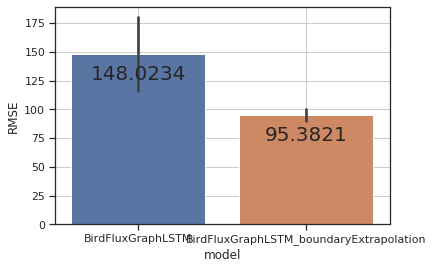

In [14]:
fig = utils.plot_average_errors(results, boundary=[], night_only=False, horizon=64, bird_thr=0, prediction_col='prediction', target_col='gt')

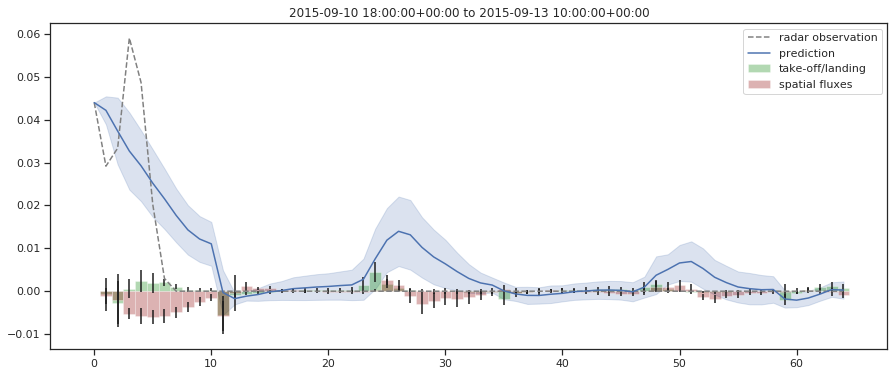

In [19]:
plot_example(results, bird_scales, 'BirdFluxGraphLSTM_boundaryExtrapolation', seqID=40, radar='defbg', trial=None, normalize=True)

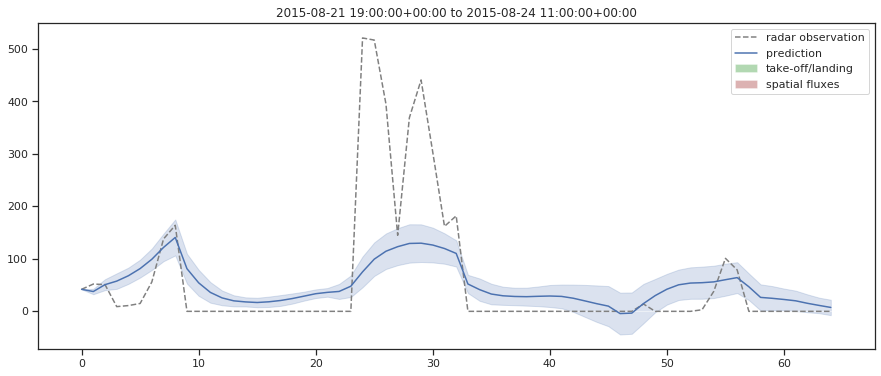

In [46]:
plot_example(results, bird_scales, 'BirdFluxGraphLSTM_boundaryExtrapolation', seqID=20, radar='deboo', trial=None, normalize=True)

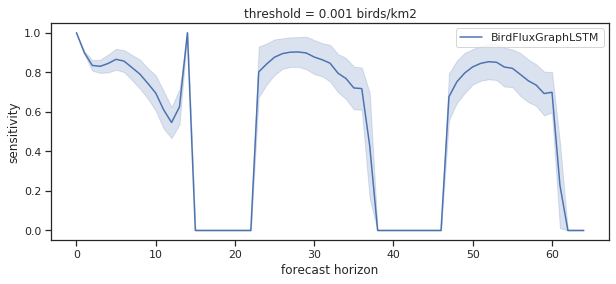

In [17]:
fig = plot_classification_performance(results, thr=0.001, metric='sensitivity')

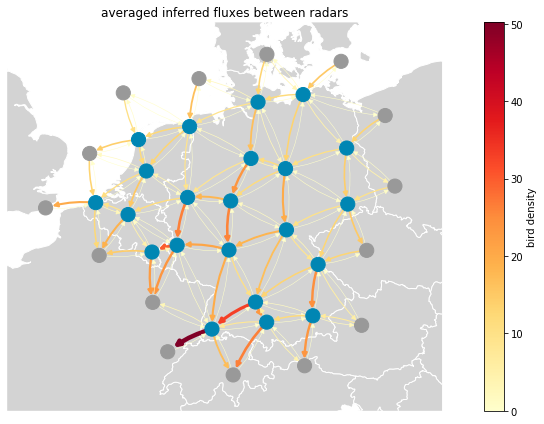

In [142]:
m = 'BirdFluxGraphLSTM_boundaryExtrapolation'
summary = results[m].groupby('trial').residual_km2.aggregate(compute_rmse)
best_trial = summary.argmax()
voronoi = gpd.read_file('/home/fiona/birdMigration/data/preprocessed/1H/voronoi_dummy_radars=15_exclude=[]/radar/fall/2015/voronoi.shp')
inner_radars = voronoi.query('boundary == False').index.values
G_path = '/home/fiona/birdMigration/data/preprocessed/1H/voronoi_dummy_radars=15_exclude=[]/radar/fall/2015/delaunay.gpickle'
G = nx.read_gpickle(G_path)

d = '/home/fiona/birdMigration/data/shapes'
countries = gpd.read_file(osp.join(d, 'ne_10m_admin_0_countries_lakes.shp'))


#crs = ccrs.PlateCaree()
crs = ccrs.AlbersEqualArea(central_longitude=8, central_latitude=50)
fig, ax = plt.subplots(figsize=(12, 6), subplot_kw = {'projection' : crs})
ax.set_extent([0, 17, 45.5, 56])
f = ShapelyFeature(countries.geometry,
                                ccrs.PlateCarree(), edgecolor='white')
ax.add_feature(f, facecolor='lightgray', zorder=0)
G_new, ax, max_flux = plot_fluxes(voronoi, G, fluxes[m][0], results[m], trial=best_trial, encoder=1, context=0, horizon=64, 
                        bird_scale=bird_scales[m], ax=ax, crs=crs.proj4_init)
# ax.gridlines(crs=ccrs.PlateCarree(), draw_labels=True,
#                  linewidth=2, color='gray', alpha=0.2, linestyle='--')
plt.tight_layout()
fig.savefig('/home/fiona/birdMigration/data/plots/presentations/model_fluxes_abm.png', bbox_inches='tight', dpi=300)

In [119]:
G.edges()

OutEdgeView([(0, 4), (0, 6), (0, 10), (0, 14), (0, 21), (0, 22), (4, 0), (4, 6), (4, 9), (4, 10), (4, 15), (4, 35), (6, 0), (6, 4), (6, 22), (6, 35), (6, 36), (10, 0), (10, 1), (10, 4), (10, 5), (10, 9), (10, 12), (10, 14), (14, 0), (14, 1), (14, 10), (14, 13), (14, 21), (14, 23), (14, 24), (21, 0), (21, 14), (21, 22), (21, 23), (22, 0), (22, 6), (22, 21), (22, 23), (22, 36), (1, 5), (1, 10), (1, 13), (1, 14), (1, 17), (5, 1), (5, 2), (5, 10), (5, 12), (5, 17), (13, 1), (13, 7), (13, 14), (13, 17), (13, 24), (13, 25), (17, 1), (17, 2), (17, 3), (17, 5), (17, 7), (17, 11), (17, 13), (2, 5), (2, 8), (2, 11), (2, 12), (2, 17), (2, 20), (8, 2), (8, 11), (8, 16), (8, 20), (8, 29), (8, 30), (11, 2), (11, 3), (11, 8), (11, 17), (11, 28), (11, 29), (12, 2), (12, 5), (12, 9), (12, 10), (12, 18), (12, 20), (20, 2), (20, 8), (20, 12), (20, 16), (20, 18), (20, 19), (3, 7), (3, 11), (3, 17), (3, 27), (3, 28), (7, 3), (7, 13), (7, 17), (7, 25), (7, 26), (7, 27), (27, 3), (27, 7), (27, 26), (27, 28),

In [37]:
abm_flux_matrix = np.load('/home/fiona/birdMigration/data/raw/abm/fall/2015/outfluxes.npy')
abm_fluxes = prepare_abm_fluxes(abm_flux_matrix, results['BirdFluxGraphLSTM_boundaryExtrapolation'])

103


In [38]:
G_path = '/home/fiona/birdMigration/data/preprocessed/1H/voronoi_dummy_radars=15_exclude=[]/radar/fall/2015/delaunay.gpickle'
G = nx.read_gpickle(G_path)
voronoi_flux_ratio(abm_flux_matrix, G)

(0.9976607314004963, 0.7380200003987654)

In [40]:
99.8 - 73.8

26.0

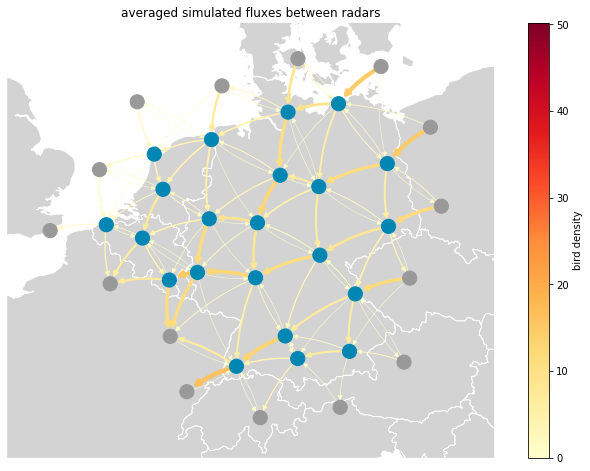

In [145]:
crs = ccrs.AlbersEqualArea(central_longitude=8, central_latitude=50)
fig, ax = plt.subplots(figsize=(12, 8), subplot_kw = {'projection' : crs})
ax.set_extent([0, 17, 45.5, 56])
f = ShapelyFeature(countries.geometry,
                                ccrs.PlateCarree(), edgecolor='white')
ax.add_feature(f, facecolor='lightgray', zorder=0)
G_new, ax, max_flux = plot_fluxes(voronoi, G, abm_fluxes, results[m], trial=best_trial, encoder=1, context=0, horizon=64, 
                         bird_scale=1, abm=True, ax=ax, crs=crs.proj4_init, max_flux=max_flux)
fig.savefig('/home/fiona/birdMigration/data/plots/presentations/simulated_fluxes_abm.png', bbox_inches='tight', dpi=300)

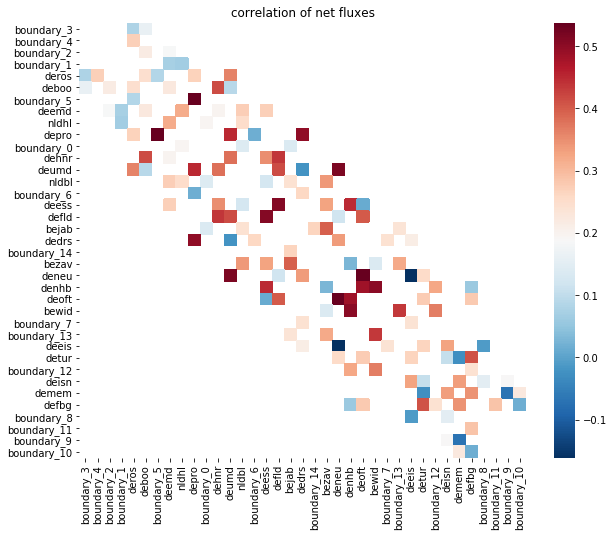

In [146]:
corr, angles, avg_rflux, avg_mflux = flux_corr_matrix(radar_idx[m], voronoi, G, results[m], fluxes[m][0], abm_fluxes, best_trial, context=24, horizon=40, abm=True)


[Text(0, 0.5, 'correlation coefficient'), Text(0.5, 0, 'avg abs model flux')]

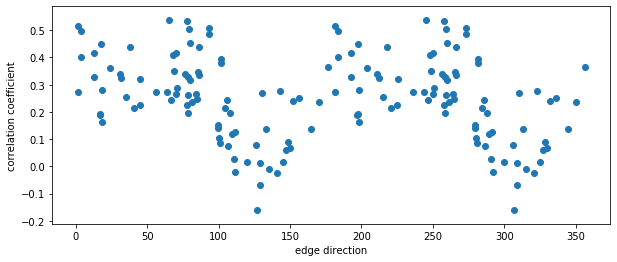

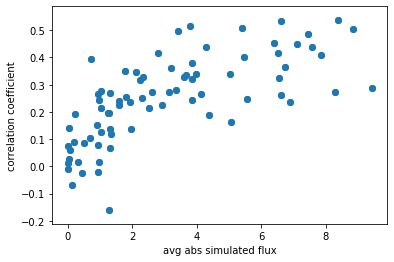

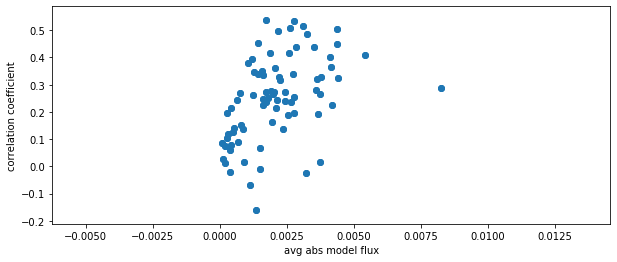

In [147]:
fig, ax = plt.subplots(figsize=(10, 4))
ax.scatter(angles.flatten(), corr.flatten())
ax.set(xlabel='edge direction', ylabel='correlation coefficient')
fig.savefig('/home/fiona/birdMigration/data/plots/presentations/corr_vs_edge_direction_abm.png', bbox_inches='tight', dpi=300)

fig, ax = plt.subplots(figsize=(6, 4))
ax.scatter(avg_rflux.flatten(), corr.flatten())
ax.set(xlabel='avg abs simulated flux', ylabel='correlation coefficient')
fig.savefig('/home/fiona/birdMigration/data/plots/presentations/corr_vs_abs_flux_abm.png', bbox_inches='tight', dpi=300)

fig, ax = plt.subplots(figsize=(10, 4))
ax.scatter(avg_mflux.flatten(), corr.flatten())
ax.set(xlabel='avg abs model flux', ylabel='correlation coefficient')

(37, 37, 4017)
true_pos = 0.061097390452863096, true_neg = 0.0
RMSE = 4.57604399961876e-06


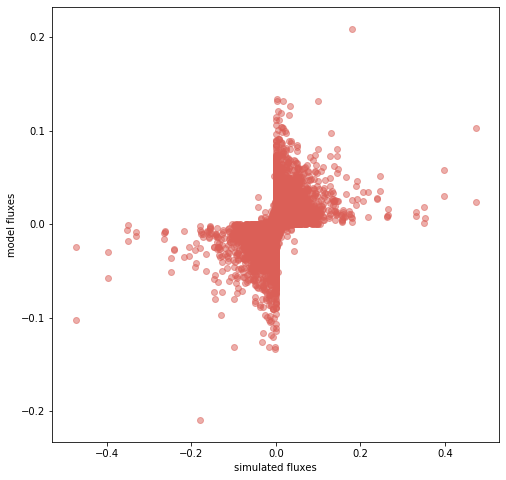

In [148]:
fig = compare_fluxes_radar(voronoi, radar_idx[m], results, fluxes[m][0], abm_fluxes, trial=best_trial, encoder=1, 
                           context=24, bird_scales=bird_scales, m=m, horizon=40, radar=None, abm=True)
fig.savefig('/home/fiona/birdMigration/data/plots/presentations/model_vs_simulated_fluxes_abm.png', bbox_inches='tight', dpi=300)

In [13]:
m = 'BirdFluxGraphLSTM_boundaryExtrapolation'
radar_idx_inv = {r: i for i, r in radar_idx[m].items()}
df = results[m]
abm_departure = np.load('/home/fiona/birdMigration/data/raw/abm/fall/2015/departing_birds.npy')
abm_landing = np.load('/home/fiona/birdMigration/data/raw/abm/fall/2015/landing_birds.npy')

In [18]:
tidx = df.tidx.to_numpy()
ridx = np.array([radar_idx_inv[r] for r in df.radar.values])
dep = abm_departure[tidx, ridx]
lan = abm_landing[tidx, ridx]
df['gt_delta'] = (dep - lan) / bird_scales[m]

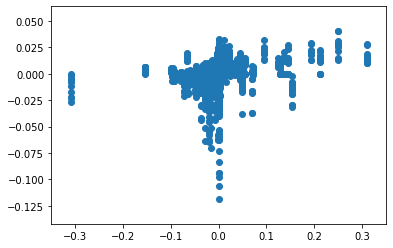

In [20]:
radar = 'deboo'
plt.scatter(df.query('radar == @radar').gt_delta.values, df.query('radar == @radar').local_deltas.values)